# How to wait for another node

## Introduction
WorkTree launch a node when its input nodes are finished. However, sometimes you want to wait for another node (not the input nodes) to finish before running the next node. For example, the input is from a data in the `context`, and you want to wait for the data to be ready.

In this tutorial, you will learn how to use `node.wait` to wait for other nodes to finish.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='4a9501fb20364cecb99920cadf27b238' name='xing'>

## First workflow
Here we create two `add` nodes and one `sum` node. The `sum` node will wait for the two `add` nodes to finish.

In [2]:
from aiida_worktree import node, WorkTree
from aiida.engine import calcfunction
from aiida.orm import Float

# define add node
@node()
@calcfunction
def add(x, y):
    return x + y

# define sum node
@node()
@calcfunction
def sum(**datas):
    total = 0
    for data in datas.values():
        total += data.value
    return Float(total)


In [3]:
from aiida_worktree import WorkTree
from aiida.orm import Int, List

wt = WorkTree("test_wait")
add1 = wt.nodes.new(add, name="add1", x=1, y=1)
add1.to_ctx = [["result", "data.add1"]]
add2 = wt.nodes.new(add, name="add2", x=2, y=2)
add2.to_ctx = [["result", "data.add2"]]
# let sum node wait for add1 and add2, and the `data` in the context is ready
sum3 = wt.nodes.new(sum, name="sum1", datas="{{data}}")
sum3.wait=["add1", "add2"]
wt.submit(wait=True)

[INFO] 2023-08-04 20:45:45 nodetree: Create NodeTree: test_wait


### Check status and results


In [4]:
print("State of WorkTree         : {}".format(wt.state))
print('Result of sum1: {}'.format(wt.nodes["sum1"].node.outputs.result.value))

State of WorkTree         : FINISHED
Result of sum1: 6.0


Generate node graph from the AiiDA process,and we can see that the `multiply` node is executed.

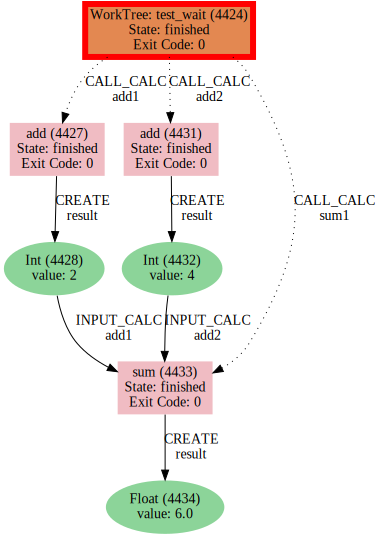

In [5]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt.pk)